In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from scipy.ndimage import shift, rotate, zoom
from sklearn.decomposition import PCA

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


 Создаем переменные пути и считываем тренировочную и тестовую выборку

In [2]:
train_path = f"{dirname}/{filenames[1]}"
test_path = f"{dirname}/{filenames[2]}"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [3]:
X_train = train_data.drop('label', axis=1).values
y_train = train_data.label.values
X_test = test_data.values
print(X_train.shape)
print(y_train.shape)
print(test_data.shape)

(42000, 784)
(42000,)
(28000, 784)


In [4]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


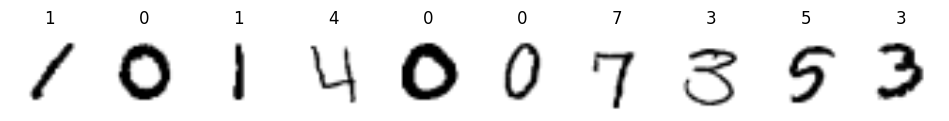

In [5]:
_, ax = plt.subplots(1, 10, figsize=(12, 8))
for i in range(10):
    digit = X_train[i].reshape(28, 28)
    ax[i].imshow(digit, cmap=plt.cm.binary, interpolation='bilinear')
    ax[i].set_axis_off()
    ax[i].set_title(y_train[i])

In [6]:
# pca = PCA(n_components=50)
# X_pca = pca.fit_transform(X_train)
# X_pca_test = pca.fit_transform(test_data)
# print('Shape before PCA: {}. Shape after PCA: {}'.format(X_train.shape, X_pca.shape))
# print('Shape before PCA: {}. Shape after PCA: {}'.format(test_data.shape, X_pca_test.shape))

In [7]:
def shift_in_one_direction(image, direction):
    """
    Shifts an image by one pixel in the specified direction
    """
    if direction == "DOWN":
        image = shift(image, [1, 0])
    elif direction == "UP":
        image = shift(image, [-1, 0])
    elif direction == "LEFT":
        image = shift(image, [0, -1])
    else:
        image = shift(image, [0, 1])

    return image


def shift_in_all_directions(image):
    """
    Shifts an image in all the directions by one pixel
    """
    reshaped_image = image.reshape(28, 28)

    down_shifted_image = shift_in_one_direction(reshaped_image, "DOWN")
    up_shifted_image = shift_in_one_direction(reshaped_image, "UP")
    left_shifted_image = shift_in_one_direction(reshaped_image, "LEFT")
    right_shifted_image = shift_in_one_direction(reshaped_image, "RIGHT")

    return (down_shifted_image, up_shifted_image,
            left_shifted_image, right_shifted_image)


def rotate_in_all_directions(image, angle):
    """
    Rotates an image clockwise and anti-clockwise
    """
    reshaped_image = image.reshape(28, 28)
    
    rotated_images = (rotate(reshaped_image, angle, reshape=False),
                      rotate(reshaped_image, -angle, reshape=False))
    
    return rotated_images


def clipped_zoom(image, zoom_ranges):
    """
    Clips and zooms an image at the specified zooming ranges
    """
    reshaped_image = image.reshape(28, 28)
    
    h, w = reshaped_image.shape
    
    zoomed_images = []
    for zoom_range in zoom_ranges:
        zh = int(np.round(h / zoom_range))
        zw = int(np.round(w / zoom_range))
        top = (h - zh) // 2
        left = (w - zw) // 2
        
        zoomed_images.append(zoom(reshaped_image[top:top+zh, left:left+zw],
                                  zoom_range))
    
    return zoomed_images

def alter_image(image):
    """
    Alters an image by shifting, rotating, and zooming it
    """
    shifted_images = shift_in_all_directions(image)
    rotated_images = rotate_in_all_directions(image, 10)
    zoomed_images = clipped_zoom(image, [1.1, 1.2])
            
    return np.r_[shifted_images, rotated_images, zoomed_images]

X_train_add = np.apply_along_axis(alter_image, 1, X_train).reshape(-1, 784)
y_train_add = np.repeat(y_train, 8)

print(f"X_train_add shape: {X_train_add.shape}")
print(f"y_train_add shape: {y_train_add.shape}")

X_train_add shape: (336000, 784)
y_train_add shape: (336000,)


In [8]:
X_train_combined = np.r_[X_train, X_train_add]
y_train_combined = np.r_[y_train, y_train_add]

del X_train
del X_train_add
del y_train
del y_train_add

print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"y_train_combined shape: {y_train_combined.shape}")

X_train_combined shape: (378000, 784)
y_train_combined shape: (378000,)


In [9]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
knn.fit(X_train_combined, y_train_combined)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [10]:
y_pred = knn.predict(X_test)

In [11]:
stop = len(test_data)+1
df = pd.DataFrame(dict(ImageId=range(1, stop), Label=y_pred))
df.to_csv('submission.csv', index=False)